In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

h2o.init(max_mem_size=12, min_mem_size=10)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 24.80-b11, mixed mode)
  Starting server from C:\Users\xuchu\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\xuchu\AppData\Local\Temp\tmp711x3qk8
  JVM stdout: C:\Users\xuchu\AppData\Local\Temp\tmp711x3qk8\h2o_ChuanXu_started_from_python.out
  JVM stderr: C:\Users\xuchu\AppData\Local\Temp\tmp711x3qk8\h2o_ChuanXu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_ChuanXu_rnakkd
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [ ]:
# This is the basic file after cleaning the incorrect inputs
# The df_train only contains the models in the original training file
data_file = "clean_data/yancheng_train_20171226_01282017.csv"

# Python forces to set the low_memory to False, otherwise worning will be threw
df_train = pd.read_csv(data_file, low_memory=False, header=0, parse_dates=[0])
# Drop price_level and price since there are too many missing values
# df_train.drop(['price'], axis=1, inplace=True)
# I don't know why but the dataframe has several row which are full of NaNs at the end, drop them.
df_train = df_train[:20154]
# Transfter categorical data from numerical values to str
df_train['if_charging'].replace(
    to_replace=[0, 1], value=['L', 'T'], inplace=True)
df_train['gearbox_type'].replace(to_replace=[1, 2, 3, 4, 5, 6, 7, ],
                                 value=['AMT', 'AT', 'ATDCT', 'CVT', 'DCT', 'MT', 'MTAT'], inplace=True)

# Try to detrend by changing date to two categorical attributes
df_train['year'] = [i.year for i in pd.to_datetime(
    df_train['sale_date'], format="%Y%m")]
df_train['month'] = [i.month for i in pd.to_datetime(
    df_train['sale_date'], format="%Y%m")]
df_train.drop(['sale_date'], axis=1, inplace=True)

# Features having no ordinance need to transfer to str
to_change_list = ['class_id', 'brand_id', 'type_id', 'level_id', 'department_id', 'TR', 'driven_type_id',
                  'fuel_type_id', 'newenergy_type_id', 'emission_standards_id', 'if_MPV_id',
                  'if_luxurious_id', 'cylinder_number', 'rated_passenger', 'compartment', 'year', 'month']
df_train[to_change_list] = df_train[to_change_list].astype(int).astype(str)

# # Change the missinng values in 'price' to NaN and transfer them to numerical
df_train['price'].replace('-', np.nan, inplace=True)
df_train['price'] = df_train['price'].astype(float)

# double check there is no NaN anymore
# print(df_train.isnull().sum())

In [ ]:
# Save after cleansing training data and new generated test data
df_train.to_csv("clean_data/yancheng_train_20171226_02012018.csv", index=False)
df_test.to_csv("clean_data/yancheng_test_20171226_02012018.csv", index=False)

In [ ]:
# This cell is a new way to clean data by dropping multiple models under the same clas_id and only keep
# the one with most accumulated sales
str_list = ['class_id', 'brand_id', 'type_id', 'level_id', 'department_id', 'TR', 'driven_type_id',
            'fuel_type_id', 'newenergy_type_id', 'emission_standards_id', 'if_MPV_id',
            'if_luxurious_id', 'cylinder_number', 'rated_passenger', 'compartment', 'year', 'month']
dtype_dict = {i: str for i in str_list}
raw_df = pd.read_csv(
    "clean_data/yancheng_train_20171226_01292017.csv", header=0, dtype=dtype_dict)
df_train = raw_df.groupby(['class_id', 'year', 'month']).sum()[
    'sale_quantity'].reset_index()
class_id_list = list(set(df_train['class_id']))
temp = raw_df.groupby(['class_id', 'equipment_quality']).sum()[
    'sale_quantity'].reset_index()
equipment_quality_list = []
for i in class_id_list:
    temp1 = temp.loc[temp.loc[temp['class_id'] == i,
                              'sale_quantity'].idxmax(), 'equipment_quality']
    equipment_quality_list.append(temp1)

temp = raw_df.sort_values(['year', 'month'], ascending=False)
temp1 = temp[(temp['class_id'] == class_id_list[0]) &
             (temp['equipment_quality'] == equipment_quality_list[0])].iloc[0, :].drop(['sale_quantity', 'year', 'month'])
temp2 = pd.DataFrame([], index=range(len(class_id_list)),
                     columns=temp1.index.values)
temp2.iloc[0, :] = temp1
for i in range(1, len(class_id_list)):
    temp3 = temp[(temp['class_id'] == class_id_list[i]) &
                 (temp['equipment_quality'] == equipment_quality_list[i])].iloc[0, :].drop(['sale_quantity', 'year', 'month'])
    temp2.iloc[i, :] = temp3

df_train = df_train.merge(temp2)

In [3]:
# This cell is to generate the data with full model information under each month
to_str_list = ['class_id', 'brand_id', 'type_id', 'level_id', 'department_id', 'TR', 'driven_type_id',
               'fuel_type_id', 'newenergy_type_id', 'emission_standards_id', 'if_MPV_id',
               'if_luxurious_id', 'cylinder_number', 'rated_passenger', 'compartment', 'year', 'month']
to_group_list = ['class_id', 'brand_id', 'compartment', 'type_id',
                 'level_id', 'department_id', 'TR', 'gearbox_type', 'displacement',
                 'if_charging', 'driven_type_id', 'fuel_type_id',
                 'newenergy_type_id', 'emission_standards_id', 'if_MPV_id',
                 'if_luxurious_id', 'power', 'cylinder_number', 'engine_torque',
                 'car_length', 'car_width', 'car_height', 'total_quality',
                 'equipment_quality', 'rated_passenger', 'wheelbase', 'front_track',
                 'rear_track', 'price_level']
dtype_dict = {i: str for i in to_str_list}
df_train = pd.read_csv(
    "clean_data/yancheng_train_20171226_01292017.csv", header=0, dtype=dtype_dict)
print(df_train.shape)
class_id_list = list(set(df_train.class_id.values))
full_data_df = pd.DataFrame(columns=df_train.columns.values)
for i in class_id_list:
    one_class_df = df_train[df_train['class_id'] == i]
    one_class_df = one_class_df.groupby(
        to_group_list+['year', 'month'])['sale_quantity'].sum().reset_index()
    year_list = list(set(one_class_df.year.unique()))
    one_class_full_date_df = pd.DataFrame(
        columns=['class_id', 'year', 'month'])
    for j in year_list:
        month_list = one_class_df[one_class_df.year == j].month.unique()
        temp1 = pd.DataFrame(month_list, columns=['month'], index=[
                             i]*len(month_list)).reset_index()
        temp1.columns = ['class_id', 'month']
        temp2 = pd.DataFrame([j], columns=['year'], index=[i]).reset_index()
        temp2.columns = ['class_id', 'year']
        temp3 = pd.merge(temp2, temp1, how='left', on=['class_id'])
        one_class_full_date_df = pd.concat([one_class_full_date_df, temp3])
    one_class_unique_model_df = one_class_df.groupby(
        to_group_list).size().reset_index().drop([0], axis=1)
    one_class_ns_full_df = pd.merge(one_class_unique_model_df, one_class_full_date_df,
                                    how='left', on=['class_id'])
    one_class_full_df = pd.merge(one_class_df, one_class_ns_full_df,
                                 how='right', on=(to_group_list+['year', 'month']))
    one_class_full_df.sort_values(['year', 'month'], inplace=True)
    one_class_full_df.fillna(value={'sale_quantity': 0}, inplace=True)
    full_data_df = full_data_df.append(one_class_full_df, ignore_index=True)

(20154, 33)


In [19]:
full_data_df.to_csv("clean_data/yancheng_train_20171226_02202018.csv", index=False)
print(full_data_df.shape)
# full_data_df.dtypes
full_data_df.isnull().sum()

,A,B
0,1,NaN
1,2,NaN
2,3,NaN
0,4,5.0
1,7,8.0


In [3]:
# Read the data with full model information under each month
to_str_list = ['class_id', 'brand_id', 'type_id', 'level_id', 'department_id', 'TR', 'driven_type_id',
               'fuel_type_id', 'newenergy_type_id', 'emission_standards_id', 'if_MPV_id',
               'if_luxurious_id', 'cylinder_number', 'rated_passenger', 'compartment', 'year', 'month']
dtype_dict = {i: str for i in to_str_list}
full_data_df = pd.read_csv(
    "clean_data/yancheng_train_20171226_02042018.csv", header=0, dtype=dtype_dict)
full_data_df.shape

(76018, 33)

In [4]:
# Drop the price column which contains too many missing values
df_train = full_data_df
full_data_df.isnull().sum()
print(len(full_data_df['brand_id'].unique()))
full_data_df['brand_id'].unique()
# df_train.drop('price', inplace=True, axis=1)
# df_test

36


array(['814', '497', '807', '783', '637', '692', '836', '953', '750',
       '106', '537', '12', '761', '872', '638', '542', '290', '76', '864',
       '450', '923', '49', '75', '98', '831', '813', '68', '498', '682',
       '236', '985', '304', '841', '294', '126', '512'], dtype=object)

In [5]:
# Score:124
# df_train = full_data_df[(full_data_df.price_level=='25-35W')|(full_data_df.price_level=='35-50W')|
#                         (full_data_df.price_level=='50-75W')]
# Score: 104
# df_train = full_data_df[(full_data_df.displacement <= 1.5) & (full_data_df.displacement >= 1.3) &
#                        (full_data_df.gearbox_type == 'MT')]
# Score: 110
# df_train = full_data_df[(full_data_df.displacement <= 1.5) & (full_data_df.displacement >= 1.3) &
#                        (full_data_df.gearbox_type != 'MT')]
# Score: 86
# df_train = full_data_df[full_data_df.displacement <= 1.3]
# Score: 57
# df_train = full_data_df[full_data_df.cylinder_number == '3']
# Score: 108
# df_train = full_data_df[(full_data_df.displacement >= 1.5) & (full_data_df.displacement <= 1.8) &
#                        (full_data_df.gearbox_type == 'MT')]
# Score: 82
# df_train = full_data_df[(full_data_df.displacement >= 1.5) & (full_data_df.displacement <= 1.8) &
#                        (full_data_df.gearbox_type == 'CVT')]
# Score: 56
df_train = full_data_df[(full_data_df.displacement >= 1.8) & (full_data_df.displacement <= 2.0) &
                       (full_data_df.gearbox_type == 'MT')]
print(df_train.shape)
print(len(df_train.class_id.unique()))
print(df_train[(df_train.year=='2017')&(df_train.month=='10')].shape)
df_train.drop('price',axis=1,inplace=True)

(5482, 33)
36
(97, 33)


C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [76]:
# low_disp_list = list(df_train.class_id.unique())
df_train.gearbox_type.unique()

array(['AT', 'MT', 'DCT', 'CVT', 'AMT'], dtype=object)

In [279]:
# Generate test data by droping 'sale_quantity' and changing 'month' to '11'
df_test = df_train[df_train['year']=='2017']
df_test = df_test[df_test['month']=='10']
df_test['month'] = '11'
df_test.drop(['sale_quantity'], axis=1, inplace=True)
df_test.index = range(df_test.shape[0])
df_test.shape

(7, 31)

In [280]:
# Change pd.df to H20.df
h2o_df_train = h2o.H2OFrame(df_train)
h2o_df_test = h2o.H2OFrame(df_test)
# h2o_df_train, h2o_df_valid = h2o_df.split_frame(ratios=[.8])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [282]:
rf_model = h2o.load_model('model/DRF_model_python_1518135767970_44')

In [283]:
# Make predictio
preds = rf_model.predict(h2o_df_test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [ ]:
# Generate the sale_prediction containing the prediction for each model for further analysis
raw_predict_df = df_test
raw_predict_df["sale_predict"] = preds_res_list
raw_predict_df.to_csv("clean_data/raw_prediction_01292017.csv")

In [284]:
# Generate the file to submit, some more works are needed in Excel
result_df = pd.DataFrame(df_test.iloc[:,0].values, columns=['class_id'])
preds_res_list= h2o.as_list(preds) 
result_df['sale_predict'] = preds_res_list
result_df.groupby('class_id',axis=0).sum().to_csv("clean_data/prediction_02082018_294.csv")

In [ ]:
# Save result
result_comp_df.to_csv("clean_data/prediction_01302017.csv")

In [ ]:
# Load model
rf_model = h2o.load_model('model/DRF_model_python_1517980413637_3')

In [ ]:
# Save model
model_path = h2o.save_model(model=rf_model, path="model", force=True)

In [ ]:
# Plot feature importance and some performance measure
print(rf_model.show())
print(pd.DataFrame(rf_model.summary().as_data_frame()))
print(pd.DataFrame(rf_model.varimp()))
print(pd.DataFrame(rf_model.scoring_history()))
rf_model.varimp_plot()
rf_model.plot()

In [58]:
# Fill the price and drop those with empty price, create lag terms for price
class_id_list = list(set(df_train['class_id'].values))
column_list = list(df_train.columns.values)
column_list.remove('price')
df_train1 = pd.DataFrame(columns=(column_list+['date', 'price','price_lag_1']))
for i in class_id_list:
    temp = df_train[df_train['class_id']==i]
#     if temp['price'].isnull().sum() < temp.shape[0]:
    temp['date'] = pd.to_datetime([(temp.loc[i,'year']+temp.loc[i,'month']) for i in temp.index],
                         format='%Y%m')
    temp.sort_values(['date','price'], inplace=True)
    temp.fillna(method='ffill', inplace=True)
#         temp.dropna(inplace=True)
    temp1 = temp[['price','date']].groupby('date').mean().reset_index()
    temp.drop('price',axis=1,inplace=True)
    temp2 = pd.concat([temp1, temp1['price'].shift()], axis=1)
    temp2.columns = ['date', 'price', 'price_lag_1']
    temp3 = pd.merge(temp, temp2, how='left', on=['date'])
    df_train1 = pd.concat([df_train1,temp3])
df_train1.shape

C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\xuchu\Anaconda3\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

(61098, 35)

In [65]:
# Load the datframe with lag terms
# df_train1.to_csv("clean_data/yancheng_train_20171226_02072018_lag.csv",index=False)
# to_str_list = ['class_id','brand_id','type_id','level_id','department_id','TR','driven_type_id',
#             'fuel_type_id','newenergy_type_id','emission_standards_id','if_MPV_id',
#             'if_luxurious_id','cylinder_number','rated_passenger','compartment','year','month']
# dtype_dict = {i:str for i in to_str_list}
# df_train = pd.read_csv("clean_data/yancheng_train_20171226_02072018_lag.csv",header=0,dtype=dtype_dict)
# df_train = df_train1
basic_drop_list = ['price']
element_drop_list = ['date','price']
groupby_drop_list = ['date','price','if_luxurious_id','if_MPV_id']
df_train.drop(basic_drop_list,axis=1,inplace=True)
# print(len(df_train['class_id'].unique()))
print(df_train.shape)
df_train.dtypes

d:\anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(295, 32)


class_id                  object
sale_quantity            float64
brand_id                  object
compartment               object
type_id                   object
level_id                  object
department_id             object
TR                        object
gearbox_type              object
displacement             float64
if_charging               object
price_level               object
driven_type_id            object
fuel_type_id              object
newenergy_type_id         object
emission_standards_id     object
if_MPV_id                 object
if_luxurious_id           object
power                    float64
cylinder_number           object
engine_torque            float64
car_length               float64
car_width                float64
car_height               float64
total_quality            float64
equipment_quality        float64
rated_passenger           object
wheelbase                float64
front_track              float64
rear_track               float64
year      

In [7]:
# This is to drop additional month
df_train.drop(df_train[(df_train['year']=='2017')
                                      & (df_train['month']=='10')].index, axis=0, inplace=True)

C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1518213174606_2


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 666.193224333596
RMSE: 25.810719175055855
MAE: 6.396249640603542
RMSLE: 1.0295390733151497
Mean Residual Deviance: 666.193224333596

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 708.7152399580351
RMSE: 26.621706180446722
MAE: 6.731645418050772
RMSLE: 1.0608831856786913
Mean Residual Deviance: 708.7152399580351
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,6.7371736,0.2364489,6.1824255,6.7763557,7.213253,6.6511607,6.8626723
mean_residual_deviance,710.4865,118.2036360,409.05173,748.52026,759.2222,922.6899,712.9485
mse,710.4865,118.2036360,409.05173,748.52026,759.2222,922.6899,712.9485
r2,0.689907,0.0471609,0.7401944,0.5636867,0.7082902,0.7485747,0.6887892
residual_deviance,710.4865,118.2036360,409.05173,748.52026,759.2222,922.6899,712.9485
rmse,26.443005,2.3721368,20.225027,27.359098,27.553988,30.37581,26.701096
rmsle,1.0604063,0.0143489,1.093794,1.0595906,1.0298156,1.0611135,1.0577182


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2018-02-09 16:54:14,10.154 sec,0.0,nan,nan,nan
,2018-02-09 16:54:14,10.168 sec,1.0,29.8559493,7.2043893,891.3777071
,2018-02-09 16:54:14,10.181 sec,2.0,28.0788540,6.6622093,788.4220416
,2018-02-09 16:54:14,10.194 sec,3.0,30.4451172,7.0503438,926.9051609
,2018-02-09 16:54:14,10.208 sec,4.0,28.6991312,6.7208913,823.6401333
---,---,---,---,---,---,---
,2018-02-09 16:54:15,11.366 sec,96.0,25.9314051,6.4203950,672.4377709
,2018-02-09 16:54:15,11.378 sec,97.0,25.9274643,6.4244732,672.2334048
,2018-02-09 16:54:15,11.394 sec,98.0,25.9126886,6.4121488,671.4674283
,2018-02-09 16:54:15,11.407 sec,99.0,25.8154091,6.4032410,666.4353445



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
month,143166592.0000000,1.0,0.1889269
emission_standards_id,136558688.0000000,0.9538447,0.1802069
year,118070592.0000000,0.8247077,0.1558094
equipment_quality,94830024.0000000,0.6623754,0.1251405
price_level,77276232.0000000,0.5397644,0.1019760
---,---,---,---
driven_type_id,552483.8125000,0.0038590,0.0007291
displacement,377199.1250000,0.0026347,0.0004978
compartment,299316.7812500,0.0020907,0.0003950
fuel_type_id,71208.9843750,0.0004974,0.0000940



See the whole table with table.as_data_frame()
None
     number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              100.0                     100.0             986450.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       19.0       20.0       19.96       625.0       924.0       781.86  
                        0             1         2         3
0                   month  1.431666e+08  1.000000  0.188927
1   emission_standards_id  1.365587e+08  0.953845  0.180207
2                    year  1.180706e+08  0.824708  0.155809
3       equipment_quality  9.483002e+07  0.662375  0.125141
4             price_level  7.727623e+07  0.539764  0.101976
5           department_id  2.798170e+07  0.195449  0.036925
6                brand_id  2.407619e+07  0.168169  0.031772
7                      TR  2.164503e+07  0.151188  0.028563
8           total_quality  2.159991e+07  0.150873  0.028504
9              car_height  2.149621e+07  0.150148  0.0

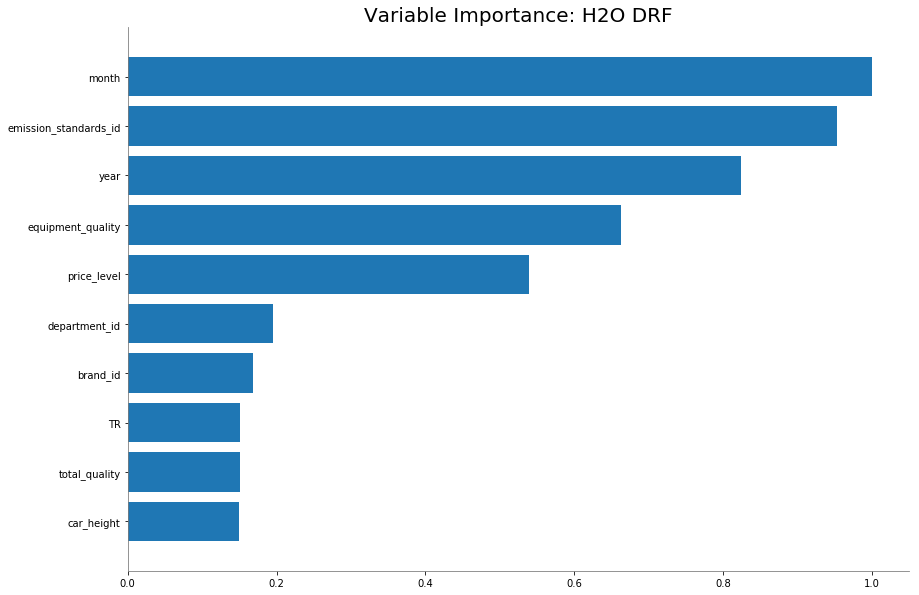

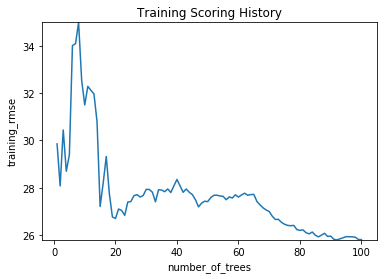

C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
56.91733772176395


In [8]:
# This cell is try to simulate the ranking score calculation
# Generate new training data to avoid overfit
train_to_drop_year = '2017'
train_to_drop_month = '9'
test_year = '2017'
test_month = '9'
sim_df_train = df_train.drop(df_train[(df_train['year']==train_to_drop_year) 
                                      & (df_train['month']==train_to_drop_month)].index, axis=0)
# Uncomment the following line if you want to out-of-sample test and set the test_year and test_month differ
# from train_to_drop_year and train_to_drop_month and train a new model
if train_to_drop_year != test_year or train_to_drop_month != test_month:
    sim_df_train.drop(df_train[(df_train['year']==test_year) 
                                      & (df_train['month']==test_month)].index, axis=0, inplace=True)
# sim_df_train.drop(['price','price_level'], axis=1, inplace=True)
sim_H2O_df_train = h2o.H2OFrame(sim_df_train)

# Choose the model you want to test
sim_model = H2ORandomForestEstimator(nfolds=5, ntrees=100, seed=1)
# sim_model = H2OGradientBoostingEstimator(nfolds=5, ntrees=400, seed=1)

features = list(sim_df_train.columns)
features.remove('sale_quantity')

# Train new model or load saved one. Someone just recommended max_depth from 15 to 20
sim_model.train(x=features,y='sale_quantity', training_frame=sim_H2O_df_train)
# sim_model = h2o.load_model('model/DRF_model_python_1518135767970_30')

# Model perforamnce
print(sim_model.show())
print(pd.DataFrame(sim_model.summary().as_data_frame()))
print(pd.DataFrame(sim_model.varimp()))
print(pd.DataFrame(sim_model.scoring_history()))
sim_model.varimp_plot()
sim_model.plot()

# Generate the test data by droping the 'sale_quantity' 
sim_df_test = df_train[(df_train.year==train_to_drop_year) & (df_train.month==train_to_drop_month)]
sim_df_test['year'] = test_year
sim_df_test['month'] = test_month
temp_df = df_train.loc[df_train[(df_train.year==train_to_drop_year) & (df_train.month==train_to_drop_month)].index, 
                       ['class_id', 'sale_quantity']].groupby('class_id').sum()
result_comp_df = pd.DataFrame(temp_df['sale_quantity'].values, columns=['real_sale_quantity'], 
                              index=temp_df.index)
real_sim_df_test = sim_df_test.drop(['sale_quantity'], axis=1)
sim_H2O_df_test = h2o.H2OFrame(real_sim_df_test)

# Use new model to make prediction
sim_preds = sim_model.predict(sim_H2O_df_test)
temp_df1 = pd.DataFrame(h2o.as_list(sim_preds).values, columns=['predict_sale_quantity'], 
                        index=sim_df_test['class_id'].values)
result_comp_df['predict_sale_quantity'] = temp_df1.groupby(temp_df1.index, 
                                                           axis=0).sum()['predict_sale_quantity'].values.astype(int)

# Calculate score
score = np.sqrt(np.sum(np.subtract(result_comp_df['predict_sale_quantity'], 
                    result_comp_df['real_sale_quantity'])**2./result_comp_df.shape[0]))
print(score)

In [193]:
# This is to generate a .csv file which contains the sale_prediction and real sale_quantity 
# for each model to further analyze
raw_predict_df = sim_df_test
raw_predict_df["sale_predict"] = h2o.as_list(sim_preds).values
raw_predict_df.to_csv("clean_data/result_comp_02082018_patrial.csv")

d:\anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [277]:
h2o.save_model(model=sim_model, path="model", force=True)

'F:\\Dropbox\\Academy\\ML Competition\\2018VehiclePred\\model\\DRF_model_python_1518135767970_44'

In [ ]:
# This cell is to do the grid search
from h2o.grid.grid_search import H2OGridSearch
# Generate new training data to avoid overfit
train_to_drop_year = '2017'
train_to_drop_month = '10'
test_year = '2017'
test_month = '10'
sim_df_train = df_train.drop(df_train[(df_train['year']==train_to_drop_year) 
                                      & (df_train['month']==train_to_drop_month)].index, axis=0)
# Uncomment the following line if you want to out-of-sample test and set the test_year and test_month differ
# from train_to_drop_year and train_to_drop_month and train a new model
# sim_df_train.drop(df_train[(df_train['year']==test_year) 
#                                       & (df_train['month']==test_month)].index, axis=0, inplace=True)
# sim_df_train.drop(['price','price_level'], axis=1, inplace=True)
sim_H2O_df_train = h2o.H2OFrame(sim_df_train)
sim_rf_model = H2ORandomForestEstimator(nfolds=5)
# sim_model = H2OGradientBoostingEstimator(nfolds=5, learn_rate=0.02, learn_rate_annealing=0.995)

# Train new model or load saved one
rf_params = {'ntrees': [i*10 for i in range(10,40,5)],
             'max_depth': list(range(10, 27, 2)),
             'sample_rate': [i * 0.1 for i in range(5, 9)]}
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36}
features = list(sim_df_train.columns)
features.remove('sale_quantity')
rf_grid = H2OGridSearch(model=sim_rf_model, 
                        hyper_params=rf_params,
                        search_criteria=search_criteria)
rf_grid.train(x=features, y='sale_quantity', training_frame=sim_H2O_df_train)

In [ ]:
# Grid search performance evaluation
rf_gridperf = rf_grid.get_grid(sort_by='residual_deviance', decreasing=False)
print(rf_gridperf)
best_rf = rf_gridperf.models[0]
print(best_rf.show())
print(pd.DataFrame(best_rf.summary().as_data_frame()))
print(pd.DataFrame(best_rf.varimp()))
print(pd.DataFrame(best_rf.scoring_history()))
best_rf.varimp_plot()
best_rf.plot()
h2o.save_model(model=best_rf, path="model", force=True)
sim_df_test = df_train.loc[df_train[(df_train.year==train_to_drop_year) 
                                    & (df_train.month==train_to_drop_month)].index, :]
# sim_df_test.drop(['price','price_level'], axis=1, inplace=True)
temp_df = df_train.loc[df_train[(df_train.year==train_to_drop_year) & (df_train.month==train_to_drop_month)].index, 
                       ['class_id', 'sale_quantity']].groupby('class_id').sum()
result_comp_df = pd.DataFrame(temp_df['sale_quantity'].values, columns=['real_sale_quantity'], 
                              index=temp_df.index)
sim_df_test.drop(['sale_quantity'], axis=1, inplace=True)
sim_H2O_df_test = h2o.H2OFrame(sim_df_test)

# Use new model to make prediction
sim_preds = best_rf.predict(sim_H2O_df_test)
temp_df1 = pd.DataFrame(h2o.as_list(sim_preds).values, columns=['predict_sale_quantity'], 
                        index=sim_df_test['class_id'].values)
result_comp_df['predict_sale_quantity'] = temp_df1.groupby(temp_df1.index, 
                                                           axis=0).sum()['predict_sale_quantity'].values.astype(int)

# Calculate score
score = np.sqrt(np.sum(np.subtract(result_comp_df['predict_sale_quantity'], 
                    result_comp_df['real_sale_quantity'])**2./result_comp_df.shape[0]))
print(score)

In [22]:
# This is for K-means clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing

to_train_list = ['displacement','power','engine_torque','car_length','car_width',
                'car_height','total_quality','equipment_quality','wheelbase','front_track','rear_track']

df_train1 = df_train[(df_train['year']=='2017')&(df_train['month']=='10')]
df_train2 = df_train1[to_train_list]
X_train_scaled = preprocessing.scale(df_train2)
df_train_scaled = pd.DataFrame(X_train_scaled, columns=to_train_list)
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_train_scaled)
labels = kmeans.predict(df_train_scaled)
df_result = df_train1
df_result['label'] = labels
df_result[df_result['label']==0]

C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,class_id,sale_quantity,brand_id,compartment,type_id,level_id,department_id,TR,gearbox_type,displacement,...,car_height,total_quality,equipment_quality,rated_passenger,wheelbase,front_track,rear_track,year,month,label
855,732758,161.0,814,2,1,1,4,6,AT,1.5,...,1624.0,2035.0,1550.0,5,2780.0,1561.0,1562.0,2017,10,0
856,732758,0.0,814,2,1,1,4,6,AT,1.5,...,1613.0,2340.0,1900.0,5,2780.0,1561.0,1562.0,2017,10,0
857,732758,0.0,814,2,1,1,4,6,AT,2.0,...,1583.0,2040.0,1560.0,5,2760.0,1500.0,1529.0,2017,10,0
858,732758,0.0,814,2,1,1,4,6,AT,2.0,...,1577.0,2010.0,1580.0,5,2760.0,1500.0,1529.0,2017,10,0
859,732758,0.0,814,2,1,1,4,6,MT,2.0,...,1577.0,1990.0,1535.0,5,2760.0,1500.0,1529.0,2017,10,0
860,732758,0.0,814,2,1,1,4,6,MT,2.0,...,1577.0,2035.0,1570.0,5,2760.0,1500.0,1529.0,2017,10,0
861,732758,0.0,814,2,1,1,4,8,AT,2.0,...,1624.0,2095.0,1607.0,5,2780.0,1561.0,1562.0,2017,10,0
862,732758,0.0,814,2,1,1,4,8,AT,2.0,...,1577.0,2060.0,1605.0,5,2760.0,1500.0,1529.0,2017,10,0
863,732758,0.0,814,2,1,1,4,8,AT,2.0,...,1583.0,2085.0,1605.0,5,2760.0,1500.0,1529.0,2017,10,0
864,732758,0.0,814,2,1,1,4,8,AT,2.0,...,1577.0,2060.0,1605.0,5,2760.0,1500.0,1529.0,2017,10,0


In [200]:
print(df_train.gearbox_type.unique())

['MT' 'AT' 'DCT' 'CVT' 'MTAT' 'AMT' 'ATDCT']


# Input and Filter Data

In [3]:
# Read the 'full' dataset
to_str_list = ['class_id', 'brand_id', 'type_id', 'level_id', 'department_id', 'TR', 'driven_type_id',
               'fuel_type_id', 'newenergy_type_id', 'emission_standards_id', 'if_MPV_id',
               'if_luxurious_id', 'cylinder_number', 'rated_passenger', 'compartment', 'year', 'month']
dtype_dict = {i: str for i in to_str_list}
full_data_df = pd.read_csv(
    "clean_data/yancheng_train_20171226_02202018.csv", header=0, dtype=dtype_dict)
df_train = full_data_df.drop('price', axis=1)

In [302]:
# Filter our the subset you want to test
# real_df_train = sim_df_train = df_train[(df_train.if_luxurious_id=='2') & (df_train.if_MPV_id=='2')]
# real_df_train = sim_df_train = df_train[df_train.brand_id=='831']
# real_df_train = sim_df_train = df_train[df_train.displacement == 2.0]
# real_df_train = sim_df_train = df_train[(df_train.displacement <= 1.8) & (df_train.displacement >= 1.6) &
#                                         ((df_train.gearbox_type == 'AT') | (df_train.gearbox_type == 'AMT'))
#                                        & (df_train.compartment == '3') & (df_train.if_charging == 'L') & 
#                                        (df_train.emission_standards_id == '1')]
# real_df_train = sim_df_train = df_train[(df_train.displacement < 2) & (df_train.displacement >= 1.6)]
real_df_train = sim_df_train = df_train
print('training set size:', sim_df_train.shape)
new_column_name = 'pre_sale_qty_' + 'Full'

training set size: (84980, 32)


# Test Method 1

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Model performance for method 1:
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1519574847989_15


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1953.351539491512
RMSE: 44.1967367516145
MAE: 19.996482383222634
RMSLE: 2.044405383613655
Mean Residual Deviance: 1953.351539491512

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 2225.099932734092
RMSE: 47.17096493325202
MAE: 21.45522778184018
RMSLE: 2.1439275967635587
Mean Residual Deviance: 2225.099932734092
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid
mae,21.369791,1.9843274,19.074291,18.50317,18.948534,21.827019,23.86019,26.005543
mean_residual_deviance,2204.177,439.92084,1643.9404,1705.1014,1558.6426,2333.5374,2785.8904,3197.9492
mse,2204.177,439.92084,1643.9404,1705.1014,1558.6426,2333.5374,2785.8904,3197.9492
r2,-0.0148139,0.0664848,-0.2045668,0.0384782,0.0824610,0.0147351,0.0336769,-0.0536682
residual_deviance,2204.177,439.92084,1643.9404,1705.1014,1558.6426,2333.5374,2785.8904,3197.9492
rmse,46.492783,4.6150794,40.545536,41.292873,39.47965,48.3067,52.781532,56.550415
rmsle,2.1453738,0.0550082,2.2655776,2.1258197,2.072115,2.0656257,2.1068137,2.2362912


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2018-02-25 12:18:29,21.208 sec,0.0,nan,nan,nan
,2018-02-25 12:18:29,21.222 sec,1.0,45.1635475,20.0503090,2039.7460257
,2018-02-25 12:18:29,21.235 sec,2.0,44.7665120,19.9314893,2004.0405931
,2018-02-25 12:18:29,21.249 sec,3.0,44.5867024,19.8238937,1987.9740317
,2018-02-25 12:18:29,21.263 sec,4.0,44.2513884,19.8489516,1958.1853773
---,---,---,---,---,---,---
,2018-02-25 12:18:32,24.202 sec,196.0,44.1928679,19.9939344,1953.0095702
,2018-02-25 12:18:32,24.216 sec,197.0,44.1925495,19.9957549,1952.9814345
,2018-02-25 12:18:32,24.232 sec,198.0,44.1965339,19.9972252,1953.3336051
,2018-02-25 12:18:32,24.248 sec,199.0,44.1968181,19.9956529,1953.3587296



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
month,89302608.0000000,1.0,0.1079800
power,68918720.0000000,0.7717436,0.0833329
equipment_quality,59988368.0000000,0.6717426,0.0725348
class_id,52480788.0000000,0.5876736,0.0634570
emission_standards_id,50492948.0000000,0.5654140,0.0610534
---,---,---,---
department_id,2221720.0,0.0248786,0.0026864
compartment,1694746.5,0.0189776,0.0020492
type_id,1692459.0,0.0189520,0.0020464
fuel_type_id,700079.5625000,0.0078394,0.0008465



See the whole table with table.as_data_frame()
None
     number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              200.0                     200.0             747709.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       15.0       15.0        15.0       202.0       389.0      293.045  
                        0             1         2         3
0                   month  8.930261e+07  1.000000  0.107980
1                   power  6.891872e+07  0.771744  0.083333
2       equipment_quality  5.998837e+07  0.671743  0.072535
3                class_id  5.248079e+07  0.587674  0.063457
4   emission_standards_id  5.049295e+07  0.565414  0.061053
5           total_quality  4.805054e+07  0.538064  0.058100
6          driven_type_id  4.685517e+07  0.524679  0.056655
7           engine_torque  4.552940e+07  0.509833  0.055052
8            displacement  4.534318e+07  0.507748  0.054827
9                      TR  4.221320e+07  0.472698  0.0

[201 rows x 7 columns]
                                   mean           sd   cv_1_valid  \
0                     mae     21.369791    1.9843274    19.074291   
1  mean_residual_deviance      2204.177    439.92084    1643.9404   
2                     mse      2204.177    439.92084    1643.9404   
3                      r2  -0.014813949   0.06648483  -0.20456682   
4       residual_deviance      2204.177    439.92084    1643.9404   
5                    rmse     46.492783    4.6150794    40.545536   
6                   rmsle     2.1453738  0.055008158    2.2655776   

    cv_2_valid  cv_3_valid   cv_4_valid   cv_5_valid    cv_6_valid  
0     18.50317   18.948534    21.827019     23.86019     26.005543  
1    1705.1014   1558.6426    2333.5374    2785.8904     3197.9492  
2    1705.1014   1558.6426    2333.5374    2785.8904     3197.9492  
3  0.038478225  0.08246104  0.014735111  0.033676907  -0.053668156  
4    1705.1014   1558.6426    2333.5374    2785.8904     3197.9492  
5    41.29

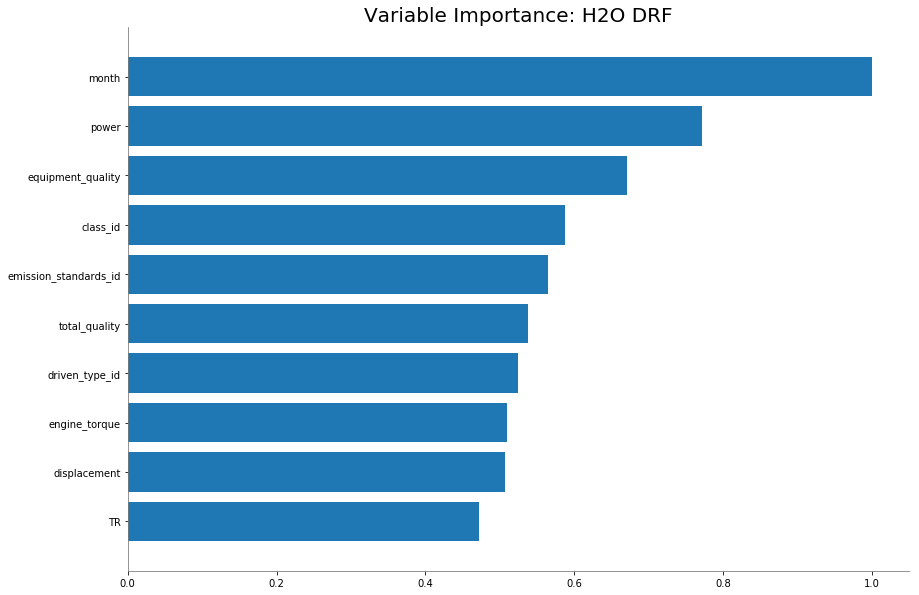

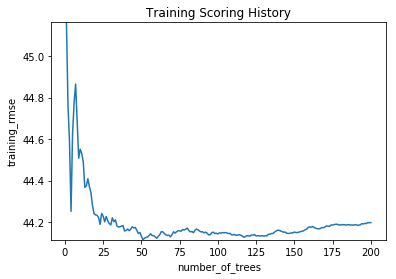

test set size: (204, 31)
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,score_1
201708,64.697355
201709,82.060373
201710,101.088352
average,82.615360


In [59]:
# This cell is to test clustering on '201708', '201709' and '201710'
# Drop data to avoid overfit and keep the real sale_quantity to calculate score
df_comp_201708 = sim_df_train[(
    sim_df_train.year == '2014') & (sim_df_train.month == '11')]
sim_df_train = sim_df_train.drop(sim_df_train[(
    sim_df_train.year == '2014') & (sim_df_train.month == '11')].index, axis=0)
df_comp_201709 = sim_df_train[(
    sim_df_train.year == '2015') & (sim_df_train.month == '11')]
sim_df_train = sim_df_train.drop(sim_df_train[(
    sim_df_train.year == '2015') & (sim_df_train.month == '11')].index, axis=0)
df_comp_201710 = sim_df_train[(sim_df_train.year == '2016') & (
    sim_df_train.month == '11')]
sim_df_train = sim_df_train.drop(sim_df_train[(
    sim_df_train.year == '2016') & (sim_df_train.month == '11')].index, axis=0)

# Train the model
sim_H2O_df_train = h2o.H2OFrame(sim_df_train)
for i in to_str_list:
    sim_H2O_df_train[i] = sim_H2O_df_train[i].asfactor()
sim_model = H2ORandomForestEstimator(ntrees=200, seed=1, max_depth=15, mtries=5)
features = list(sim_df_train.columns)
features.remove('sale_quantity')
sim_model.train(x=features, y='sale_quantity', training_frame=sim_H2O_df_train, fold_column="year")
# sim_model = h2o.load_model('model/DRF_model_python_1518135767970_43')

# Model performance
print("Model performance for method 1:")
print(sim_model.show())
print(sim_model.summary().as_data_frame())
print(pd.DataFrame(sim_model.varimp()))
print(pd.DataFrame(sim_model.scoring_history()))
print(sim_model.cross_validation_metrics_summary().as_data_frame())
sim_model.varimp_plot()
sim_model.plot()

# Make prediction
df_test_201708 = df_comp_201708.drop('sale_quantity', axis=1)
df_test_201709 = df_comp_201709.drop('sale_quantity', axis=1)
df_test_201710 = df_comp_201710.drop('sale_quantity', axis=1)
print('test set size:', df_test_201708.shape)
H2O_df_test_201708 = h2o.H2OFrame(df_test_201708)
H2O_df_test_201709 = h2o.H2OFrame(df_test_201709)
H2O_df_test_201710 = h2o.H2OFrame(df_test_201710)
preds_201708 = sim_model.predict(H2O_df_test_201708)
preds_201709 = sim_model.predict(H2O_df_test_201709)
preds_201710 = sim_model.predict(H2O_df_test_201710)

# Calculate scores
df_comp_201708['predict_sale_quantity'] = h2o.as_list(preds_201708).values
df_comp_201709['predict_sale_quantity'] = h2o.as_list(preds_201709).values
df_comp_201710['predict_sale_quantity'] = h2o.as_list(preds_201710).values

df_score_201708 = df_comp_201708.groupby('class_id').sum()
score_201708 = np.sqrt(np.sum(np.subtract(df_score_201708['predict_sale_quantity'],
                                          df_score_201708['sale_quantity'])**2./df_score_201708.shape[0]))
df_score_201709 = df_comp_201709.groupby('class_id').sum()
score_201709 = np.sqrt(np.sum(np.subtract(df_score_201709['predict_sale_quantity'],
                                          df_score_201709['sale_quantity'])**2./df_score_201709.shape[0]))
df_score_201710 = df_comp_201710.groupby('class_id').sum()
score_201710 = np.sqrt(np.sum(np.subtract(df_score_201710['predict_sale_quantity'],
                                          df_score_201710['sale_quantity'])**2./df_score_201710.shape[0]))

score_list = [score_201708, score_201709, score_201710]
score_list.append(np.mean(score_list))

result_df = pd.DataFrame(
    score_list, index=['201708', '201709', '201710', 'average'], columns=['score_1'])
result_df

In [35]:
h2o.save_model(model=sim_model, path="model", force=True)

'C:\\Users\\xuchu\\Dropbox\\Academy\\ML Competition\\2018VehiclePred\\model\\DRF_model_python_1519547750146_8'

# Test Method 2

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
training set size: (13486, 32)
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
training set size: (13282, 32)
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Model performance for method 2:
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1519257868883_48


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 485.87403915268317
RMSE: 22.042550649883584
MAE: 8.162175300998816
RMSLE: 1.2401174510975252
Mean Residual Deviance: 485.87403915268317

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 549.4260964400115
RMSE: 23.4

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,8.848737,0.3105759,8.7184725,8.438059,8.508638,8.918333,9.660179
mean_residual_deviance,550.0908,37.255383,609.7482,505.99954,496.76526,519.87823,618.0627
mse,550.0908,37.255383,609.7482,505.99954,496.76526,519.87823,618.0627
r2,0.7522572,0.0097148,0.7277761,0.7481757,0.7607628,0.7674968,0.7570747
residual_deviance,550.0908,37.255383,609.7482,505.99954,496.76526,519.87823,618.0627
rmse,23.42749,0.7885101,24.69308,22.494434,22.28823,22.800838,24.860867
rmsle,1.3053507,0.0207907,1.2878613,1.2629437,1.3177162,1.3074845,1.3507472


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2018-02-21 21:32:32,28.747 sec,0.0,nan,nan,nan
,2018-02-21 21:32:32,28.776 sec,1.0,35.9129802,11.6279430,1289.7421480
,2018-02-21 21:32:32,28.807 sec,2.0,34.3756439,10.7653710,1181.6848939
,2018-02-21 21:32:32,28.838 sec,3.0,32.1363520,10.2597365,1032.7451199
,2018-02-21 21:32:32,28.871 sec,4.0,29.6214716,9.7553118,877.4315781
---,---,---,---,---,---,---
,2018-02-21 21:32:36,32.639 sec,127.0,22.1996723,8.1835007,492.8254496
,2018-02-21 21:32:36,32.666 sec,128.0,22.2122280,8.1835854,493.3830747
,2018-02-21 21:32:36,32.694 sec,129.0,22.1998647,8.1777611,492.8339942
,2018-02-21 21:32:36,32.721 sec,130.0,22.1881003,8.1749839,492.3117960



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
year,1237571328.0000000,1.0,0.3600849
month,593839488.0000000,0.4798426,0.1727841
emission_standards_id,185088192.0000000,0.1495576,0.0538534
equipment_quality,184020624.0000000,0.1486950,0.0535428
price_level,158067680.0000000,0.1277241,0.0459915
---,---,---,---
compartment,4055662.0,0.0032771,0.0011800
type_id,3894051.0,0.0031465,0.0011330
department_id,3494942.5,0.0028240,0.0010169
fuel_type_id,888001.5625000,0.0007175,0.0002584



See the whole table with table.as_data_frame()
None
     number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              200.0                     200.0            4397925.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       20.0       20.0        20.0      1435.0      1960.0       1749.8  
                        0             1         2         3
0                    year  1.237571e+09  1.000000  0.360085
1                   month  5.938395e+08  0.479843  0.172784
2   emission_standards_id  1.850882e+08  0.149558  0.053853
3       equipment_quality  1.840206e+08  0.148695  0.053543
4             price_level  1.580677e+08  0.127724  0.045992
5                   power  1.578242e+08  0.127527  0.045921
6           total_quality  1.092623e+08  0.088288  0.031791
7              car_height  9.692750e+07  0.078321  0.028202
8             front_track  7.621534e+07  0.061585  0.022176
9              car_length  7.553322e+07  0.061033  0.0

131      8.162175         485.874039  


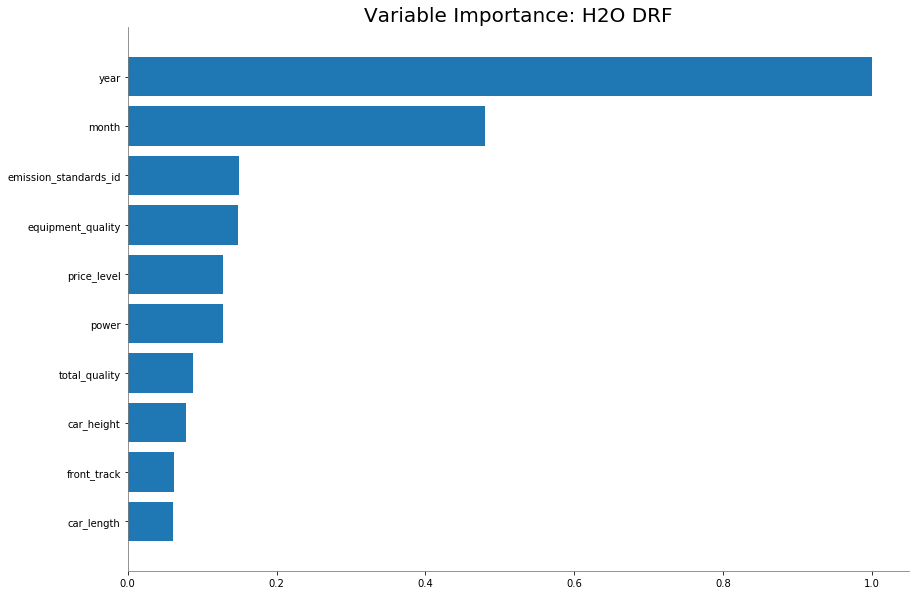

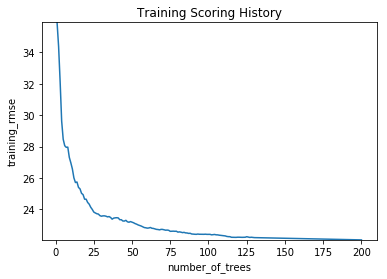

test set size: (204, 31)
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,score_1,score_2,average
201708,60.629947,60.629947,60.629947
201709,74.989469,63.586517,69.287993
201710,69.529828,56.788579,63.159204
average,68.383081,60.335014,64.359048


In [115]:
# Drop data to avoid overfit and keep the real sale_quantity to calculate score
df_comp_201710 = sim_df_train[(sim_df_train.year == '2016') & (
    sim_df_train.month == '11')]
sim_df_train = sim_df_train.drop(sim_df_train[(
    sim_df_train.year == '2016') & (sim_df_train.month == '11')].index, axis=0)
sim_H2O_df_train = h2o.H2OFrame(sim_df_train)
for i in to_str_list:
    sim_H2O_df_train[i] = sim_H2O_df_train[i].asfactor()
sim_model_1 = H2ORandomForestEstimator(nfolds=5, ntrees=200, seed=1)
sim_model_1.train(x=features, y='sale_quantity', training_frame=sim_H2O_df_train)
# sim_model_1 = h2o.load_model('model/DRF_model_python_1518121847549_11')
df_comp_201709 = sim_df_train[(
    sim_df_train.year == '2015') & (sim_df_train.month == '11')]
sim_df_train = sim_df_train.drop(sim_df_train[(
    sim_df_train.year == '2015') & (sim_df_train.month == '11')].index, axis=0)
print('training set size:', sim_df_train.shape)
sim_H2O_df_train = h2o.H2OFrame(sim_df_train)
for i in to_str_list:
    sim_H2O_df_train[i] = sim_H2O_df_train[i].asfactor()
sim_model_2 = H2ORandomForestEstimator(nfolds=5, ntrees=200, seed=1)
sim_model_2.train(x=features, y='sale_quantity',
                  training_frame=sim_H2O_df_train)
df_comp_201708 = sim_df_train[(
    sim_df_train.year == '2014') & (sim_df_train.month == '11')]
sim_df_train = sim_df_train.drop(sim_df_train[(
    sim_df_train.year == '2014') & (sim_df_train.month == '11')].index, axis=0)
print('training set size:', sim_df_train.shape)
sim_H2O_df_train = h2o.H2OFrame(sim_df_train)
for i in to_str_list:
    sim_H2O_df_train[i] = sim_H2O_df_train[i].asfactor()
sim_model_3 = H2ORandomForestEstimator(nfolds=5, ntrees=200, seed=1)
sim_model_3.train(x=features, y='sale_quantity',
                  training_frame=sim_H2O_df_train)

# Model performance
print("Model performance for method 2:")
print(sim_model_1.show())
print(sim_model_1.summary().as_data_frame())
print(pd.DataFrame(sim_model_1.varimp()))
print(pd.DataFrame(sim_model_1.scoring_history()))
print(sim_model_1.cross_validation_metrics_summary().as_data_frame())
sim_model_1.varimp_plot()
sim_model_1.plot()

# Make prediction
df_test_201708 = df_comp_201708.drop('sale_quantity', axis=1)
df_test_201709 = df_comp_201709.drop('sale_quantity', axis=1)
df_test_201710 = df_comp_201710.drop('sale_quantity', axis=1)
print('test set size:', df_test_201708.shape)
H2O_df_test_201708 = h2o.H2OFrame(df_test_201708)
H2O_df_test_201709 = h2o.H2OFrame(df_test_201709)
H2O_df_test_201710 = h2o.H2OFrame(df_test_201710)
preds_201708 = sim_model_3.predict(H2O_df_test_201708)
preds_201709 = sim_model_2.predict(H2O_df_test_201709)
preds_201710 = sim_model_1.predict(H2O_df_test_201710)

# Calculate scores
df_comp_201708['predict_sale_quantity'] = h2o.as_list(preds_201708).values
df_comp_201709['predict_sale_quantity'] = h2o.as_list(preds_201709).values
df_comp_201710['predict_sale_quantity'] = h2o.as_list(preds_201710).values

df_score_201708 = df_comp_201708.groupby('class_id').sum()
score_201708 = np.sqrt(np.sum(np.subtract(df_score_201708['predict_sale_quantity'],
                                          df_score_201708['sale_quantity'])**2./df_score_201708.shape[0]))
df_score_201709 = df_comp_201709.groupby('class_id').sum()
score_201709 = np.sqrt(np.sum(np.subtract(df_score_201709['predict_sale_quantity'],
                                          df_score_201709['sale_quantity'])**2./df_score_201709.shape[0]))
df_score_201710 = df_comp_201710.groupby('class_id').sum()
score_201710 = np.sqrt(np.sum(np.subtract(df_score_201710['predict_sale_quantity'],
                                          df_score_201710['sale_quantity'])**2./df_score_201710.shape[0]))

score_list = [score_201708, score_201709, score_201710]
score_list.append(np.mean(score_list))

result_df_1 = pd.DataFrame(
    score_list, index=['201708', '201709', '201710', 'average'], columns=['score_2'])

result = pd.concat([result_df, result_df_1], axis=1)
result['average'] = result.mean(axis=1)
result

# Make prediction

C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Model performance:
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1519579207908_97


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 12025.70605965373
RMSE: 109.66178030496191
MAE: 37.53053745136717
RMSLE: 2.239820987851234
Mean Residual Deviance: 12025.70605965373

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 13719.761229372283
RMSE: 117.13138447645996
MAE: 40.38018919766159
RMSLE: 2.3205186157446995
Mean Residual Deviance: 13719.761229372283
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid
mae,39.780956,3.6637795,35.493805,35.081676,34.508568,40.832077,47.883442,44.88617
mean_residual_deviance,13272.333,2753.1248,10087.072,10480.278,9375.491,13581.047,20503.049,15607.06
mse,13272.333,2753.1248,10087.072,10480.278,9375.491,13581.047,20503.049,15607.06
r2,0.0738822,0.1125409,-0.2742096,0.0911665,0.1700872,0.1956314,0.1242868,0.1363307
residual_deviance,13272.333,2753.1248,10087.072,10480.278,9375.491,13581.047,20503.049,15607.06
rmse,114.04826,11.517944,100.43442,102.37323,96.82712,116.53775,143.18886,124.9282150
rmsle,2.3212223,0.0666992,2.412886,2.3025837,2.207289,2.1975007,2.366144,2.4409304


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2018-02-25 16:50:49,4 min 10.646 sec,0.0,nan,nan,nan
,2018-02-25 16:50:49,4 min 10.812 sec,1.0,120.1259033,39.2414100,14430.2326547
,2018-02-25 16:50:49,4 min 10.971 sec,2.0,115.8230014,38.6579587,13414.9676629
,2018-02-25 16:50:50,4 min 11.136 sec,3.0,113.8021573,38.3803807,12950.9310153
,2018-02-25 16:50:50,4 min 11.301 sec,4.0,113.1765458,38.2838969,12808.9305137
---,---,---,---,---,---,---
,2018-02-25 16:51:05,4 min 26.777 sec,104.0,109.7956431,37.5496514,12055.0832398
,2018-02-25 16:51:09,4 min 30.829 sec,131.0,109.7844266,37.5499537,12052.6203130
,2018-02-25 16:51:13,4 min 35.005 sec,158.0,109.6725251,37.5327829,12028.0627720
,2018-02-25 16:51:18,4 min 39.160 sec,183.0,109.7007800,37.5419339,12034.2611316



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
class_id,12777638912.0000000,1.0,0.1837782
month,8977286144.0000000,0.7025779,0.1291185
equipment_quality,8096647168.0000000,0.6336575,0.1164524
engine_torque,4990385664.0000000,0.3905562,0.0717757
emission_standards_id,4030658304.0000000,0.3154463,0.0579721
---,---,---,---
cylinder_number,34623292.0000000,0.0027097,0.0004980
fuel_type_id,28412276.0000000,0.0022236,0.0004086
if_MPV_id,23961972.0000000,0.0018753,0.0003446
newenergy_type_id,16566509.0000000,0.0012965,0.0002383



See the whole table with table.as_data_frame()
None
     number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              200.0                     200.0            6942006.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       15.0       15.0        15.0      1889.0      3237.0     2650.405  
                        0             1         2         3
0                class_id  1.277764e+10  1.000000  0.183778
1                   month  8.977286e+09  0.702578  0.129118
2       equipment_quality  8.096647e+09  0.633658  0.116452
3           engine_torque  4.990386e+09  0.390556  0.071776
4   emission_standards_id  4.030658e+09  0.315446  0.057972
5           total_quality  4.010556e+09  0.313873  0.057683
6            gearbox_type  3.842942e+09  0.300755  0.055272
7                   power  3.614008e+09  0.282839  0.051980
8                brand_id  2.980880e+09  0.233289  0.042873
9              car_length  2.951848e+09  0.231017  0.0

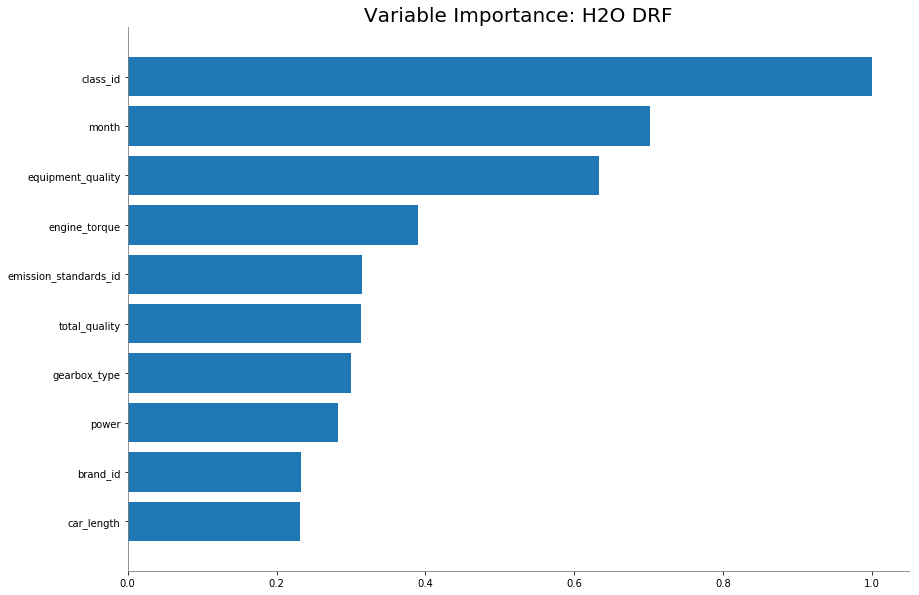

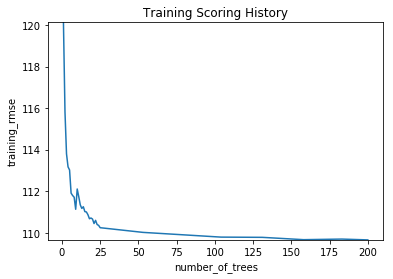

drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\xuchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


TR                       0
brand_id                 0
car_height               0
car_length               0
car_width                0
class_id                 0
compartment              0
cylinder_number          0
department_id            0
displacement             0
driven_type_id           0
emission_standards_id    0
engine_torque            0
equipment_quality        0
front_track              0
fuel_type_id             0
gearbox_type             0
if_MPV_id                0
if_charging              0
if_luxurious_id          0
level_id                 0
newenergy_type_id        0
power                    0
price_level              0
rated_passenger          0
rear_track               0
total_quality            0
type_id                  0
wheelbase                0
pre_sale_qty_Full        0
dtype: int64
(1517, 30)


In [307]:
real_df_test = real_df_train[(real_df_train.year=='2017') & (real_df_train.month=='10')]
real_df_test['month'] = '11'
real_df_test.drop('sale_quantity', axis=1, inplace=True)
real_H2O_df_train = h2o.H2OFrame(real_df_train)
for i in to_str_list:
    real_H2O_df_train[i] = real_H2O_df_train[i].asfactor()
real_H2O_df_test = h2o.H2OFrame(real_df_test)
for i in to_str_list:
    real_H2O_df_test[i] = real_H2O_df_test[i].asfactor()
features = list(real_df_train.columns)
features.remove('sale_quantity')
real_model = H2ORandomForestEstimator(ntrees=200, max_depth=15, mtries=-1, seed=1)
real_model.train(x=features, y='sale_quantity', training_frame=real_H2O_df_train, fold_column='year')
# real_model = h2o.load_model('model/DRF_model_python_1519230587617_10')

# Model performance
print("Model performance:")
print(real_model.show())
print(real_model.summary().as_data_frame())
print(pd.DataFrame(real_model.varimp()))
print(pd.DataFrame(real_model.scoring_history()))
print(real_model.cross_validation_metrics_summary().as_data_frame())
real_model.varimp_plot()
real_model.plot()

pred_res = real_model.predict(real_H2O_df_test)
real_df_test[new_column_name] = h2o.as_list(pred_res).values
real_df_test.drop(['year','month'],axis=1,inplace=True)
print(real_df_test.isnull().sum())
print(real_df_test.shape)

# Initiate result dataframe

In [315]:
res_df = full_data_df[(full_data_df.year == '2017') & (
    full_data_df.month == '10')].drop(['sale_quantity','price','year','month'], axis=1)
print(res_df.shape)
# to_str_list = ['class_id', 'brand_id', 'type_id', 'level_id', 'department_id', 'TR', 'driven_type_id',
#                'fuel_type_id', 'newenergy_type_id', 'emission_standards_id', 'if_MPV_id',
#                'if_luxurious_id', 'cylinder_number', 'rated_passenger', 'compartment']
# dtype_dict = {i: str for i in to_str_list}
# res_df = pd.read_csv("clean_data/submit_res_detail_02212018_1.csv", header=0, dtype=dtype_dict)
combine_keys = ['class_id', 'brand_id', 'compartment', 'type_id',
                'level_id', 'department_id', 'TR', 'gearbox_type', 'displacement',
                'if_charging', 'driven_type_id', 'fuel_type_id',
                'newenergy_type_id', 'emission_standards_id', 'if_MPV_id',
                'if_luxurious_id', 'power', 'cylinder_number', 'engine_torque',
                'car_length', 'car_width', 'car_height', 'total_quality',
                'equipment_quality', 'rated_passenger', 'wheelbase', 'front_track',
                'rear_track', 'price_level']

(1517, 29)


# Combine and check result

In [316]:
res_df = pd.merge(res_df, real_df_test, how='left', on=combine_keys)

In [320]:
print(res_df.shape)
print(res_df.iloc[:5,29:])
print("Data need to be filled: ", sum(res_df.iloc[:,29:].isnull().sum(axis=1)==(res_df.shape[1]-29)))
print("OK to Stop? ", sum(res_df.iloc[:,29:].isnull().sum(axis=1)<(res_df.shape[1]-29))==res_df.shape[0])

(1517, 31)
   pre_sale_qty_Full  pre_sale_quantity
0          96.211527          96.211527
1          11.093086          11.093086
2          15.252286          15.252286
3           3.427139           3.427139
4          19.734272          19.734272
Data need to be filled:  0
OK to Stop?  True


In [319]:
res_df.to_csv('clean_data/submit_res_detail_02252018_3.csv', index=False)

In [318]:
final_res_df = res_df
final_res_df['pre_sale_quantity'] = final_res_df.iloc[:, 29:].mean(axis=1)
final_res_df = final_res_df[['class_id', 'pre_sale_quantity']]
final_res_df = final_res_df.groupby('class_id').sum()
print(final_res_df.isnull().sum())
final_res_df.fillna(value={'pre_sale_quantity': 0}, inplace=True)
print(final_res_df.shape)
final_res_df.to_csv('clean_data/submit_res_02252018_3.csv')

pre_sale_quantity    0
dtype: int64
(140, 1)


In [295]:
test = res_df.iloc[:,:]
test['pre_sale_quantity'] = test.iloc[:, 29:].mean(axis=1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
test[test.pre_sale_quantity.isnull()]

,TR,brand_id,car_height,car_length,car_width,class_id,compartment,cylinder_number,department_id,displacement,driven_type_id,emission_standards_id,engine_torque,equipment_quality,front_track,fuel_type_id,gearbox_type,if_MPV_id,if_charging,if_luxurious_id,level_id,newenergy_type_id,power,price_level,rated_passenger,rear_track,total_quality,type_id,wheelbase,pre_sale_qty_lux,pre_sale_qty_537,pre_sale_qty_637,pre_sale_qty_953,pre_sale_qty_106,pre_sale_qty_872,pre_sale_qty_985,pre_sale_qty_783,pre_sale_qty_807,pre_sale_qty_813,pre_sale_qty_841,pre_sale_qty_814,pre_sale_qty_692,pre_sale_qty_836,pre_sale_qty_761,pre_sale_qty_638,pre_sale_qty_290,pre_sale_qty_304,pre_sale_qty_750,pre_sale_qty_SSmDp,pre_sale_qty_LDp,pre_sale_quantity
0,6,450,1460.0,4666.0,1807.0,349023,3,4,2,1.5,1,1,146.0,1270.0,1541.0,1,AT,2,L,1,1,1,84.0,10-15W,5,1561.0,1700.0,2,2700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,450,1477.0,4510.0,1797.0,349023,2,4,2,1.6,1,1,155.0,1380.0,1545.0,1,MT,2,L,1,1,1,86.0,10-15W,5,1567.0,1788.0,2,2685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,450,1477.0,4510.0,1797.0,349023,2,4,2,1.6,1,3,155.0,1380.0,1545.0,1,MT,2,L,1,1,1,86.0,10-15W,5,1567.0,1788.0,2,2685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,450,1459.0,4450.0,1807.0,349023,2,4,2,1.5,1,1,146.0,1280.0,1540.0,1,AT,2,L,1,1,1,84.0,10-15W,5,1561.0,1700.0,2,2700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,450,1477.0,4510.0,1797.0,349023,2,4,2,1.6,1,1,155.0,1395.0,1545.0,1,AT,2,L,1,1,1,86.0,10-15W,5,1567.0,1803.0,2,2685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,450,1477.0,4510.0,1797.0,349023,2,4,2,1.6,1,3,155.0,1395.0,1545.0,1,AT,2,L,1,1,1,86.0,10-15W,5,1567.0,1803.0,2,2685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,450,1477.0,4510.0,1797.0,349023,2,4,2,1.6,1,1,235.0,1485.0,1535.0,1,AT,2,T,1,1,1,131.0,10-15W,5,1557.0,1893.0,2,2685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,6,450,1477.0,4510.0,1797.0,349023,2,4,2,1.6,1,3,235.0,1485.0,1535.0,1,AT,2,T,1,1,1,131.0,10-15W,5,1557.0,1893.0,2,2685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,7,450,1459.0,4450.0,1807.0,349023,2,4,2,1.4,1,1,240.0,1300.0,1540.0,1,DCT,2,T,1,1,1,110.0,10-15W,5,1561.0,1740.0,2,2700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5,450,1477.0,4643.0,1797.0,349023,3,4,2,1.5,1,1,141.0,1320.0,1544.0,1,MT,2,L,1,1,1,80.0,10-15W,5,1565.0,1738.0,2,2685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [296]:
final_res_df[final_res_df.pre_sale_quantity.isnull()]

,pre_sale_quantity
class_id,
103507,NaN
169673,NaN
194201,NaN
248352,NaN
302513,NaN
347384,NaN
348641,NaN
349023,NaN
359378,NaN


In [311]:
# res_df.drop(['pre_sale_qty_SSmDp', 'pre_sale_qty_SmDpMT', 'pre_sale_qty_MDpMT',
#              'pre_sale_qty_MDpNotMT', 'pre_sale_qty_LDp'], axis=1, inplace=True)
res_df.drop('pre_sale_quantity', axis=1, inplace=True)

In [238]:
final_res_df

,pre_sale_quantity
class_id,
103507,0.000000
124140,276.819742
125403,265.581972
136916,233.410384
169673,0.000000
175962,373.219451
178529,0.000000
186250,122.680311
194201,0.000000
